<div style="text-align: center;">
  <h1>TA136 - Taller de Procesamiento de Señales</h1>
  <h2>Trabajo Práctico 7: PCA</h2>
</div>

---
---

<div style="text-align: center;">
  <h3> Introducción
</div>

&ensp; En el presente trabajo práctico se estudia el funcionamiento del algoritmo *PCA* aplicado a la base de datos *Fashion MNIST*, que contiene imágenes en escala de grises de prendas de vestir clasificadas en $10$ categorías diferentes. Se implementa el algoritmo desde cero, lo que permite una comprensión profunda de lo desarrollado en las clases teóricas.

&ensp; Se analiza el comportamiento de *PCA* evaluando el error cuadrático medio en la reconstrucción de imágenes y observando visualmente los resultados para los primeros $k = \left\{1, ~ 100, ~ 784 \right\}$ componentes principales. Además, se examina el porcentaje de energía retenida y la variación del ECM en función de la cantidad de componentes principales utilizados.

&ensp; Por último, se extiende la aplicación del modelo combinando los datos con la base *MNIST* para evaluar su capacidad como detector de anomalías, utilizando el error cuadrático medio y evaluando su desempeño mediante las curvas *ROC*.

---
---

<div style="text-align: center;">
  <h3> Desarollo
</div>

**La base de datos FASHION-MNIST posee imágenes de diferentes prendas de vestir, pertenecientes a 10 clases diferentes. Se desea entrenar un algoritmo de PCA.**

---

**(A). Cargar la base de datos utilizando $\texttt{tensorflow.keras.datasets.fashion\_mnist.load\_data}$. Utilizando $\texttt{imshow}$ (`matplotlib`) represente 10 muestras del conjunto de testeo elegidas al azar. ¿Qué tipo de prenda representa cada categoría?**

&ensp; En un principio, se carga el conjunto de datos de imágenes *Fashion MNIST* utilizando la función recomendada por la cátedra. A partir de la misma, se obtienen tanto los conjuntos de entrenamiento (`X_train` e `Y_train`) como los de testeo (`X_test`e `Y_test`). Además, se verifica que cada una de los conjuntos tenga la dimensión especificada en la librería.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

print("X_train dimensiones: ", X_train.shape)
print("Y_train dimensiones: ", Y_train.shape)
print("X_test dimensiones: ", X_test.shape)
print("Y_test dimensiones: ", Y_test.shape)

X_train dimensiones:  (60000, 28, 28)
Y_train dimensiones:  (60000,)
X_test dimensiones:  (10000, 28, 28)
Y_test dimensiones:  (10000,)


&ensp; Luego, en base a la función $\texttt{imshow}$ de la librería `matplotlib` se grafican $10$ imágenes aleatorias del conjunto de testeo.

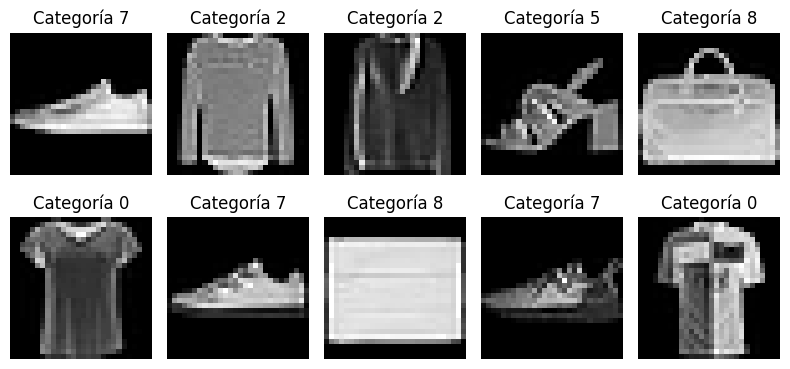

In [ ]:
index_samples = np.random.randint(0, X_test.shape[0], 10)

plt.figure(figsize=(8, 4))
for i in range(10):
  plt.subplot(2, 5, i + 1)
  plt.imshow(X_test[index_samples[i]], cmap='gray')
  plt.title("Categoría " + str(Y_test[index_samples[i]]))
  plt.axis('off')

plt.tight_layout()
plt.show()

&ensp; De esta manera y según lo que se puede visualizar en la [página oficial de TensorFlow](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data), cada prenda está asociada a una categoría de la siguiente forma:

<div align="center">

| Categoría     | Prendas      |
|:-------------:|:------------:|
| 0             | Remeras      |
| 1             | Pantalones   |
| 2             | Pullovers    |
| 3             | Vestidos     |
| 4             | Abrigos      |
| 5             | Sandalías    |
| 6             | Polleras     |
| 7             | Zapatillas   |
| 8             | Bolsos       |
| 9             | Botas        |

</div>

---

**(B). Implementar el algoritmo de PCA utilizando $\texttt{linalg.eig}$ (`numpy`). El código debe estar estructurdo de la siguiente manera (implementar todos los métodos mencionados):**
```python
class PCA:
    
    # Inicializar atributos y declarar hiperparámetros. No aclarar aún la dimensión
    # del espacio latente
    def __init__(self, ...

    # Etapa de entrenamiento. Se entrenan todos los autovectores, sin definir la
    # dimensión latente
    def fit(self, X):

    # Transformar del espacio original al espacio latente de dimensión k.
    def transform(self, X, k):

    # Transformar del espacio latente al espacio original
    def inverse_transform(self, U):

    # fit + transform
    def fit_transform(self,X,k):

    # transform + inverse_transform. Debe incluir la posiblidad de aprovechar
    # reconstrucciones ya efectuadas con menos cantidad de componentes.
    def transform_reconstruction(self, X, k, use_previous_results = False):

    # fit + transform_reconstruction. No es necesario utilizar resultados
    # anteriores pues entrenamiento hay uno solo.
    def fit_reconstruction(self, X, k):
```

&ensp; El algoritmo *PCA* se basa en la idea del *Mainfold*, que establece que los datos pueden representarse de forma más simple, reduciendo su cantidad de dimensiones sin perder información esencial. Esto es similar a lo que se realiza a partir de *autoencoders*, donde un sistema que comprime los datos y luego intenta reconstruirlos a partir de esa versión resumida. Así, *PCA* transforma los datos a un espacio más compacto y luego los reconstruye usando solo la información más importante.

&ensp; El algoritmo sigue los pasos que se visualizan a continuación.

1. Se normalizan los datos, restando su media y dividiendo por el desvío estandar.

$$ \tilde{X} = \frac{X - \mu_X}{\sigma_X}$$

2. Se busca el autoversor $v_1$. Para ello, se quiere minimizar el error cuadrático medio de la proyección de cada dato $\tilde{x}_i$ sobre el vector unitario $v_1$.
$$ \min_{v_1 : ||v_1||^2 = 1} \sum_{i=1}^n \left| \left| \tilde{x}_i - \alpha_i \cdot v_1 \right| \right|^2 ~~~~~~ \text{con} ~~~~~ \left<\tilde{x}_i - \alpha_i \cdot v_1, ~ v_1\right> = 0;$$
de la condición de ortogonalidad entre la proyección de $\tilde{x}_i$ y $v_1$, se tiene:
$$\left<\tilde{x}_i - \alpha_i \cdot v_1, ~ v_1\right> = 0 \Longrightarrow \alpha_i = \left<\tilde{x}_i, ~ v_1\right>.$$
Entonces, volviendo a la expresión que se quiere minimizar:
\begin{align*}
\min_{v_1 : ||v_1||^2 = 1} \sum_{i=1}^n \left| \left| \tilde{x}_i - \alpha_i \cdot v_1 \right| \right|^2 &= \min_{v_1 : ||v_1||^2 = 1} \sum_{i=1}^n \left| \left| \tilde{x}_i \right| \right|^2 - 2 \cdot \alpha_i \cdot \left<\tilde{x}_i, ~ v_1 \right> + \alpha_i^2 \cdot \left| \left| v_1 \right| \right|^2 \\
&= \min_{v_1 : ||v_1||^2 = 1} \sum_{i=1}^n \left| \left| \tilde{x}_i \right| \right|^2 - 2 \cdot \alpha_i \cdot \left<\tilde{x}_i, ~ v_1 \right> + \alpha_i^2 \\
&= \min_{v_1 : ||v_1||^2 = 1} - \sum_{i=1}^n  2 \cdot \alpha_i \cdot \left<\tilde{x}_i, ~ v_1 \right>.
\end{align*}
Esto se debe a que es la única expresión que depende de la variable a minimizar. Además, como la minimización de una resta es equivalente a la maximización de una suma, se tiene:
\begin{align*}
 \min_{v_1 : ||v_1||^2 = 1} - \sum_{i=1}^n  2 \cdot \alpha_i \cdot \left<\tilde{x}_i, ~ v_1 \right> & = \max_{v_1 : ||v_1||^2 = 1} \sum_{i=1}^n 2 \cdot \alpha_i \cdot \left<\tilde{x}_i, ~ v_1 \right> \\
 &= \max_{v_1 : ||v_1||^2 = 1} \sum_{i=1}^n \alpha_i \cdot \left<\tilde{x}_i, ~ v_1 \right> \\
 &= \max_{v_1 : ||v_1||^2 = 1} \frac{1}{n} \sum_{i=1}^n \left<\tilde{x}_i, ~ v_1 \right>^2 \\
 &= \max_{v_1 : ||v_1||^2 = 1} \frac{1}{n} \sum_{i=1}^n \left(v_1^T \cdot \tilde{x}_i \right) \cdot \left(\tilde{x}_i^T \cdot v_1\right) \\
 &= \max_{v_1 : ||v_1||^2 = 1} v_1^T ~ \frac{1}{n} \sum_{i=1}^n \tilde{x}_i  \tilde{x}_i^T ~ v_1 \\
 &= \max_{v_1 : ||v_1||^2 = 1} v_1^T ~ \Sigma ~ v_1.
\end{align*}
Resolviendo esto por multiplicadores de Lagrange, la función a optimizar es:
$$ J(v_1) =  v_1^T ~ \Sigma ~ v_1 - \lambda (v_1^T ~ v_1 - 1);$$
de donde se obtiene:
$$ \nabla J(v_1) = \Sigma ~ v_1 - \lambda ~ v_1 = 0 \Longrightarrow v_1^T ~ \Sigma ~ v_1 = \lambda.$$
Reemplazando esto en la expresión a maximizar.
\begin{align*}
  \max_{v_1 : ||v_1||^2 = 1} v_1^T ~ \Sigma ~ v_1 = \max_{v_1 : ||v_1||^2 = 1} \lambda = \lambda_{\text{máx}}.
\end{align*}
De este modo, se concluye que el valor que minimiza el error cuadrático entre las muestras y su proyección sobre $v_1$ corresponde al mayor autovalor de la matriz de covarianza. Además, se tiene que $v_1$ es el autovector asociado a este autovalor.

3. El desarrollo anterior se puede realizar para encontrar cada uno de los componentes principales. El resultado son los autovalores ordenados en forma decreciente y sus respectivos autovectores.


&ensp;

&ensp; Por otro lado, teniendo en cuenta todo el desarrollo efectuado anteriormente, se implementa la clase denominada $\texttt{PCA}$. A continuación, se describen los métodos de la clase:

- `__init__:` Inicializa la clase y declara los atributos necesarios para almacenar los parámetros del modelo, tales como la media y el desvío estándar para normalizar; los autovalores y autovectores; los datos reconstruidos y el valor de la dimensión $k$ a la que se transforma.

- `fit:` Ajusta el modelo a los datos de entrenamiento. Para ello, realiza los siguientes pasos:
    1. Calcula la media y el desvío estándar de los datos $\mu_X, \sigma_x \in \mathbb{R}^{1 \times 784}$ para normalizarlos.

    2. Calcula la matriz de covarianza $\Sigma \in \mathbb{R}^{784 \times 784}$ considerando que los datos están ordenados con las columnas como variables y las filas como realizaciones.

    3. Calcula los autovalores y autovectores de la matriz de covarianza y los ordena en orden decreciente.
    \begin{align*}
      V =
      \begin{bmatrix}
      v_1 & v_2 & \dots & v_{784}
      \end{bmatrix} \in \mathbb{R}^{784 \times 784}, ~
      \Lambda =
      \begin{bmatrix}
      \lambda_1 & 0 & \dots & 0 \\
      0 & \lambda_2 & \dots & 0 \\
       \vdots & \vdots & \ddots &  \vdots\\
       0 & 0 & \dots & \lambda_{784}
      \end{bmatrix} \in \mathbb{R}^{784 \times 784}
    \end{align*}

- `transform:` Proyecta los datos normalizados en un espacio latente de dimensión $k$. Para esto se utiliza la siguiente expresión:
$$U_k = V_k \cdot \tilde{X} ;$$
donde $U_k$ es la variable latente, $\tilde{X}$ son los datos normalizados y $V_k$ es la matriz de autovectores más importantes, es decir, la dada por los primeros $k$ autovectores.

- `inverse_transform:` Reconstruye los datos originales a partir de su variable latente $U$:
$$ \hat{X}^k = V_k^T \cdot U;$$
siendo $\hat{X}^k$ los datos reconstruidos sin normalizar a partir de la dimensión $k$. Además, almacena los datos reconstruidos y la dimensión $k$ desde la cual se reconstruye.

- `fit_transform:` Realiza en un solo paso el entrenamiento y la transformación del conjunto de datos $X$ al espacio de dimensión $k$.

- `transform_reconstruction:` Realiza en un solo paso la transformación del conjunto de datos $X$ al espacio de dimensión $k$ y la reconstrucción de los datos desde dicho espacio reducido. Si `use_previous_results = True`, aprovecha reconstrucciones previamente calculadas con menos componentes para evitar reprocesar toda la información. Para analizar como se debe calcular esto, se desarrolla lo siguiente:

  - En primer lugar, se calcula la variable latente para una transformación de dimensión $k$.
  \begin{align*}
    U_k = X \cdot V_k &=
    \begin{bmatrix}
      \overline{\hspace{0.5cm}} & x_1 & \overline{\hspace{0.5cm}} \\
      \overline{\hspace{0.5cm}} & x_2 & \overline{\hspace{0.5cm}} \\
       & \vdots &  \\
      \overline{\hspace{0.5cm}} & x_n & \overline{\hspace{0.5cm}}
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
      | & | &  & | \\
      v_1 & v_2 & \dots & v_k \\
      | & | &  & |
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
      x_1 \cdot v_1 & x_1 \cdot v_2 & \dots & x_1 \cdot v_k \\
      x_2 \cdot v_1 & x_2 \cdot v_2 & \dots & x_2 \cdot v_k \\
      \vdots & \vdots & \dots & \vdots \\
      x_n \cdot v_1 & x_n \cdot v_2 & \dots & x_n \cdot v_k \\
    \end{bmatrix}
  \end{align*}

  - Luego, se procede de igual forma para una transformación de dimensión $k + \Delta k$ y se relacionan ambas variables latentes.
  \begin{align*}
    U_{k+\Delta k} = X \cdot V_{k + \Delta k} &=
    \begin{bmatrix}
      \overline{\hspace{0.5cm}} & x_1 & \overline{\hspace{0.5cm}} \\
      \overline{\hspace{0.5cm}} & x_2 & \overline{\hspace{0.5cm}} \\
       & \vdots &  \\
      \overline{\hspace{0.5cm}} & x_n & \overline{\hspace{0.5cm}}
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
      | & | &  & | &  & | \\
      v_1 & v_2 & \dots & v_k & \dots & v_{k + \Delta k}\\
      | & | &  & | &  & |
    \end{bmatrix} \\
    &=
    \underbrace{\begin{bmatrix}
      x_1 \cdot v_1 & x_1 \cdot v_2 & \dots & x_1 \cdot v_k & \dots & x_1 \cdot v_{k +\Delta k} \\
      x_2 \cdot v_1 & x_2 \cdot v_2 & \dots & x_2 \cdot v_k & \dots & x_2 \cdot v_{k +\Delta k} \\
      \vdots & \vdots & \dots & \vdots & \dots & \vdots \\
      x_n \cdot v_1 & x_n \cdot v_2 & \dots & x_n \cdot v_k & \dots & x_n \cdot v_{k +\Delta k}\\
    \end{bmatrix}}_{\begin{bmatrix} U_k &  U_{k, ~ k + \Delta k} \end{bmatrix}} \\
    &~ \\
    &\Longrightarrow
    U_{k + \Delta k} = \begin{bmatrix} U_k &  U_{k, ~ k + \Delta k} \end{bmatrix}
\end{align*}

  - Ahora, se calcula la reconstrucción desde la dimensión $k$ a la original.
  \begin{align*}
    \hat{X}^k =
    U_k \cdot V_K^T &=
    \begin{bmatrix}
      x_1 \cdot v_1 & x_1 \cdot v_2 & \dots & x_1 \cdot v_k \\
      x_2 \cdot v_1 & x_2 \cdot v_2 & \dots & x_2 \cdot v_k \\
      \vdots & \vdots & \dots & \vdots \\
      x_n \cdot v_1 & x_n \cdot v_2 & \dots & x_n \cdot v_k \\
    \end{bmatrix}
    \cdot
    \begin{bmatrix}
      | & | &  & | \\
      v_1^T & v_2^T & \dots & v_k^T \\
      | & | &  & |
    \end{bmatrix} \\
    &=
    \begin{bmatrix}
      x_1 \cdot v_1 \cdot v_1^T + x_1 \cdot v_2 \cdot  v_2^T + \dots + x_1 \cdot v_k \cdot v_k^T \\
      x_2 \cdot v_1 \cdot v_1^T + x_2 \cdot v_2 \cdot v_2^T + \dots + x_2 \cdot v_k \cdot v_k^T \\
      \vdots  \\
      x_n \cdot v_1 \cdot v_1^T + x_n \cdot v_2 \cdot v_2^T + \dots + x_n \cdot v_k \cdot v_k^T \\
    \end{bmatrix} \\
  \end{align*}

  - También, se obtiene la reconstrucción desde la dimensión $k + \Delta k$, a fin de encontrar una relación entre reconstrucciones.
  \begin{align*}
  \hat{X}^{k + \Delta k} = U_{k + \Delta k} \cdot V_{k + \Delta k}^T &=
  \begin{bmatrix}
    x_1 \cdot v_1 & x_1 \cdot v_2 & \dots & x_1 \cdot v_k & \dots & x_1 \cdot v_{k +\Delta k} \\
    x_2 \cdot v_1 & x_2 \cdot v_2 & \dots & x_2 \cdot v_k & \dots & x_2 \cdot v_{k +\Delta k} \\
    \vdots & \vdots & \dots & \vdots & \dots & \vdots \\
    x_n \cdot v_1 & x_n \cdot v_2 & \dots & x_n \cdot v_k & \dots & x_n \cdot v_{k +\Delta k}\\
  \end{bmatrix}
  \begin{bmatrix}
    | & | &  & | &  & | \\
    v_1^T & v_2^T & \dots & v_k^T & \dots & v_{k + \Delta k}^T\\
    | & | &  & | &  & |
  \end{bmatrix} \\
  &=
  \begin{bmatrix}
    x_1 \cdot v_1 \cdot v_1^T + x_1 \cdot v_2 \cdot v_2^T + \dots + x_1 \cdot v_k \cdot v_k^T  + \dots + x_1 \cdot v_{k + \Delta k} \cdot v_{k + \Delta k}^T \\
    x_2 \cdot v_1 \cdot v_1^T + x_2 \cdot v_2 \cdot v_2^T + \dots + x_2 \cdot v_k \cdot v_k^T + \dots + x_2 \cdot v_{k + \Delta k} \cdot v_{k + \Delta k}^T\\
    \vdots \\
    x_n \cdot v_1 \cdot v_1^T + x_n \cdot v_2 \cdot v_2^T + \dots + x_n \cdot v_k \cdot v_k^T + \dots + x_n \cdot v_{k + \Delta k} \cdot v_{k + \Delta k}^T
  \end{bmatrix} \\
  &=
  \underbrace{\begin{bmatrix}
    x_1 \cdot v_1 \cdot v_1^T + x_1 \cdot v_2 \cdot  v_2^T + \dots + x_1 \cdot v_k \cdot v_k^T \\
    x_2 \cdot v_1 \cdot v_1^T + x_2 \cdot v_2 \cdot v_2^T + \dots + x_2 \cdot v_k \cdot v_k^T \\
    \vdots  \\
    x_n \cdot v_1 \cdot v_1^T + x_n \cdot v_2 \cdot v_2^T + \dots + x_n \cdot v_k \cdot v_k^T \\
  \end{bmatrix}}_{U_k \cdot V_k^T} +
  \underbrace{\begin{bmatrix}
    x_1 \cdot v_{k + 1} \cdot v_{k + 1}^T  + \dots + x_1 \cdot v_{k + \Delta k} \cdot v_{k + \Delta k}^T \\
    x_2 \cdot v_{k + 1} \cdot v_{k + 1}^T + \dots + x_2 \cdot v_{k + \Delta k} \cdot v_{k + \Delta k}^T\\
    \vdots \\
    x_n \cdot v_{k + 1} \cdot v_{k + 1}^T + \dots + x_n \cdot v_{k + \Delta k} \cdot v_{k + \Delta k}^T \\
  \end{bmatrix}}_{U_{k, ~ k + \Delta k} \cdot V_{k, ~ k + \Delta k}^T} \\
  &~ \\
  &\Longrightarrow \hat{X}^{k + \Delta k} = U_k \cdot V_k^T + U_{k, ~ k + \Delta k} \cdot V_{k, ~ k + \Delta k}^T = \begin{bmatrix} U_k & U_{k, ~ k + \Delta k} \end{bmatrix} \cdot \begin{bmatrix} V_k^T \\ V_{k, ~ k + \Delta k} \end{bmatrix}
\end{align*}

  - Este último resultado es lo que realiza el algoritmo cuando se le solicita reutilizar reconstrucciones previamente calculadas para reconstrucciones de mayor dimensión.

- `fit_reconstruction:` Realiza en un paso el entrenamiento seguido de una transformación y reconstrucción con `transform_reconstruction`. No utiliza resultados anteriores porque al haber un nuevo *fit*, cualquier cálculo previo deja de ser válido.

In [ ]:
class PCA:

    # Inicializar atributos y declarar hiperparámetros. No aclarar aún la dimensión
    # del espacio latente
    def __init__(self):
      self.mean = None
      self.sigma = None
      self.eigenvalues = None
      self.eigenvectors = None
      self.X_hat = None
      self.k = 0

    # Etapa de entrenamiento. Se entrenan todos los autovectores, sin definir la
    # dimensión latente
    def fit(self, X):
      self.mean = np.mean(X, axis = 0)
      self.sigma = np.sqrt(np.var(X, axis = 0))
      X_norm = (X - self.mean) / self.sigma
      cov_matrix_x = np.cov(X_norm, rowvar = False)

      eigenvalues, eigenvectors = np.linalg.eig(cov_matrix_x)
      id_sort = np.argsort(eigenvalues)[::-1]

      self.eigenvalues = eigenvalues[id_sort]
      self.eigenvectors = eigenvectors[:, id_sort]

    # Transformar del espacio original al espacio latente de dimensión k.
    def transform(self, X, k):
      X_norm = (X - self.mean) / self.sigma
      return X_norm @ self.eigenvectors[:, :k]

    # Transformar del espacio latente al espacio original
    def inverse_transform(self, U):
      self.k = U.shape[1]
      self.X_hat = U @ self.eigenvectors[:, :self.k].T
      return self.X_hat * self.sigma + self.mean

    # fit + transform
    def fit_transform(self, X, k):
      self.fit(X)
      return self.transform(X, k)

    # transform + inverse_transform. Debe incluir la posiblidad de aprovechar
    # reconstrucciones ya efectuadas con menos cantidad de componentes.
    def transform_reconstruction(self, X, k, use_previous_results = False):
      if use_previous_results and self.k < k and self.k != 0:
        X_norm = (X - self.mean) / self.sigma
        U_new_dim = X_norm @ self.eigenvectors[:, self.k:k]
        self.X_hat = self.X_hat + U_new_dim @ self.eigenvectors[:, self.k:k].T
        self.k = k
      else:
        U = self.transform(X, k)
        self.inverse_transform(U)

      return self.X_hat * self.sigma + self.mean

    # fit + transform_reconstruction. No es necesario utilizar resultados
    # anteriores pues entrenamiento hay uno solo.
    def fit_reconstruction(self, X, k):
      self.fit(X)
      return self.transform_reconstruction(X, k, use_previous_results = False)

---

**(C). Calcular y graficar el porcentaje de energía en función del número de componentes principales.**

&ensp; A fin de realizar este inciso, se aplanan las matrices correspondientes a los píxeles de las imágenes puesto que la clase $\texttt{PCA}$ sólo acepta matrices de dos dimensiones, no un *array* de matrices.

In [ ]:
X_train = X_train.reshape(X_train.shape[0], -1) # n x 784
X_test = X_test.reshape(X_test.shape[0], -1) # n x 784
Y_train = Y_train.reshape(Y_train.shape[0], -1) # n x 1
Y_test = Y_test.reshape(Y_test.shape[0], -1) # n x 1

&ensp; De esta manera, se inicializa la clase y se la entrena con el conjunto de datos correspondiente al entrenamiento.

In [ ]:
pca = PCA()
pca.fit(X_train)

&ensp; El porcentaje de energía hace referencia a la proporción de autovalores utilizados para realizar la transformación, es decir, para los primeros $k$ componentes, el porcentaje de energía está dado por la siguiente expresión:

$$  E \% = \frac{\sum_{i = 1}^{k} \lambda_i}{\sum_{i = 1}^{n} \lambda_i} \cdot 100$$

&ensp; Así, se obtienen tanto las sumas parciales dependiendo del autovalor $k$ incluido como la sumatoria total de los autovalores, para luego graficar el porcentaje de energía en función de la cantidad de componentes principales.

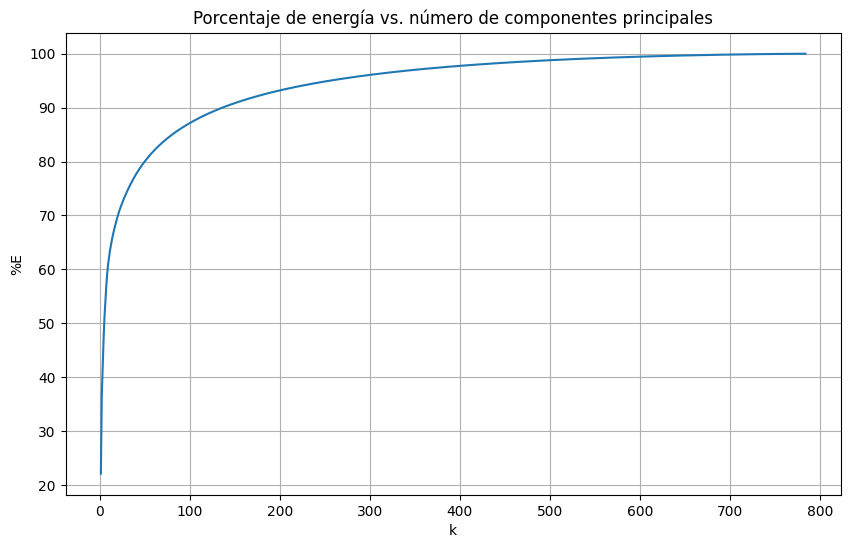

In [ ]:
total_avals = sum(pca.eigenvalues)
k_avals = np.cumsum(pca.eigenvalues)
rango_avals = range(1, len(pca.eigenvalues) + 1)

plt.figure(figsize=(10, 6))
plt.plot(rango_avals, k_avals / total_avals * 100)
plt.title("Porcentaje de energía vs. número de componentes principales")
plt.xlabel("k")
plt.ylabel("%E")
plt.grid()
plt.show()

&ensp; En esta imagen se observa claramente que, a medida que se incrementa la cantidad de autovalores considerados, el porcentaje de energía acumulada también aumenta, hasta alcanzar el 100% al incluir la totalidad de los autovalores.

---

**(D). Graficar el error cuadrático medio de testeo en función del número de componentes principales.**

&ensp; Con el objetivo de realizar este apartado, se reconstruyen los datos realizando un barrido sobre la totalidad de los componentes principales con la función $\texttt{transform\_reconstruction}$. De esta manera, se comparan los datos reconstruidos con los datos originales mediante el cálculo del error cuadrático medio:

$$\text{ECM} = \frac{1}{n} \sum_{i = 1}^n \left| \left| x_i - \hat{x}_i \right| \right|^2 $$

In [ ]:
ECM = np.zeros(len(pca.eigenvalues))

for k in range(0, len(pca.eigenvalues)):
  X_hat = pca.transform_reconstruction(X_test, k + 1, use_previous_results = True)
  ECM[k] = np.mean((X_test - X_hat) ** 2)

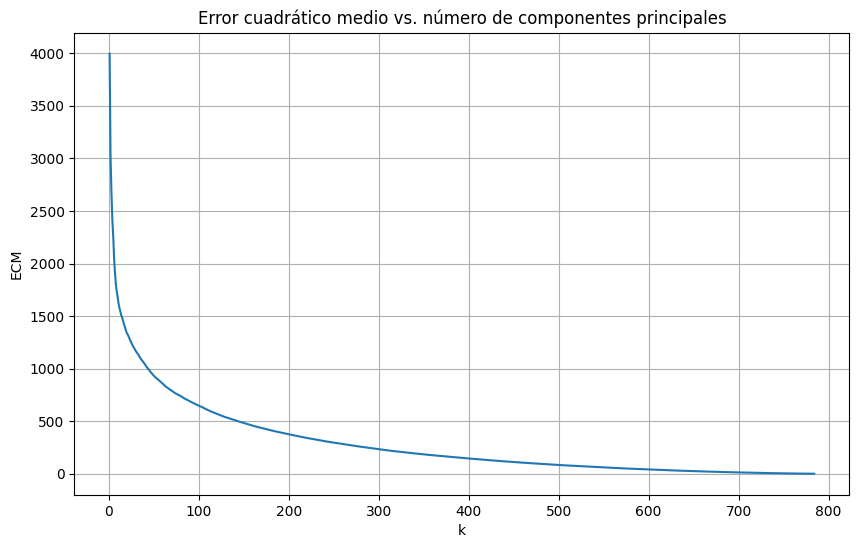

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rango_avals, ECM)
plt.title("Error cuadrático medio vs. número de componentes principales")
plt.xlabel("k")
plt.ylabel("ECM")
plt.grid()
plt.show()

&ensp; Aquí se visualiza que, al aumentar la cantidad de autovalores considerados para la transformación y posterior reconstrucción, el error cuadrático medio disminuye progresivamente. Este tiende a cero cuando se incluyen todos los componentes principales, ya que, en ese caso, no se produce una reducción de la dimensión original, y por lo tanto no se pierde información del conjunto de datos.

---

**(E). Graficar 10 imágenes reconstruidas de testeo (elegidas al azar) utilizando $1$, $100$ y $784$ componentes principales.**

&ensp; Para llevar a cabo esto, se utiliza el método $\texttt{transform\_reconstruction}$ con el algoritmo *PCA* ya entrenado, en base a los tres valores de componentes principales requeridos en la consigna.

In [ ]:
k_values = [1, 100, 784]
X_hat = np.array([pca.transform_reconstruction(X_test, k, use_previous_results = True) for k in k_values])
display(X_hat.shape)

(3, 10000, 784)

&ensp; Luego, como el método utilizado devuelve los datos con la estructura de la matriz de píxeles aplanada, se realiza una redimensión a $28 \times 28$ para poder mostrar las imágenes reconstruidas según la función $\texttt{plot\_10\_images}$, que utiliza $\texttt{imshow}$.

In [ ]:
def plot_10_images(X, k_vals):
  id_images = np.random.randint(0, X.shape[1], 10)

  for j in range(len(k_vals)):
    plt.figure(figsize=(20, 2))
    plt.suptitle("k = " + str(k_vals[j]), fontsize=16)
    for i in range(len(id_images)):
      plt.subplot(1, len(id_images), i + 1)
      plt.imshow(X[j][id_images[i]], cmap='gray')
      plt.axis('off')

    plt.axis('off')
    plt.show()

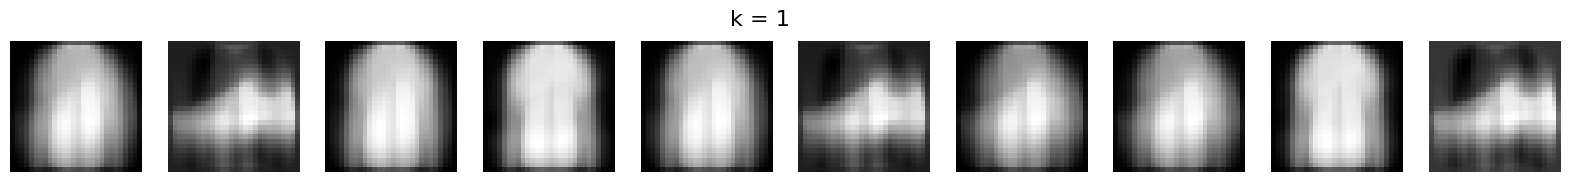

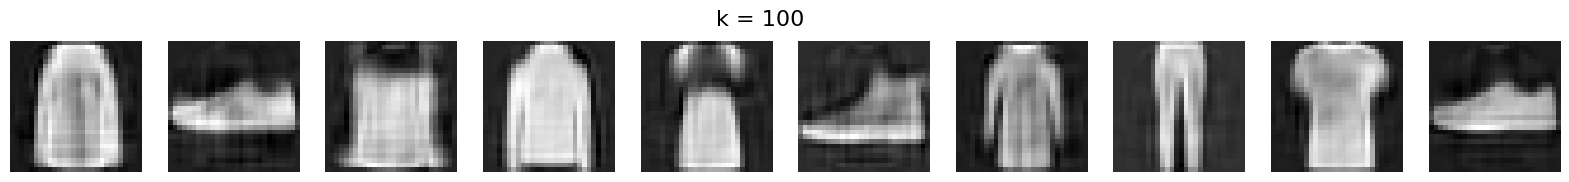

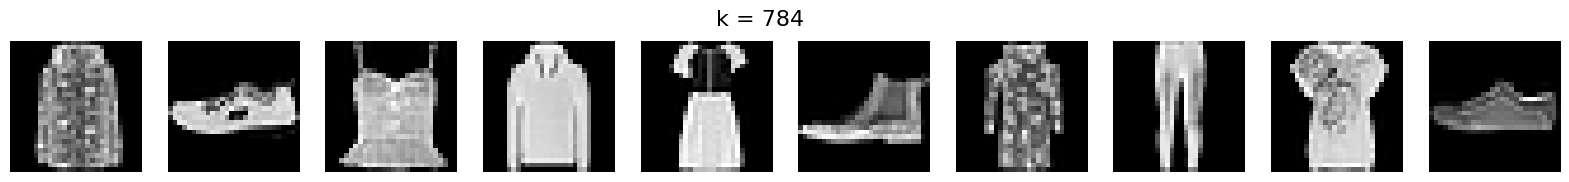

In [ ]:
X_hat = X_hat.reshape(X_hat.shape[0], X_hat.shape[1], 28, 28)
plot_10_images(X_hat, k_values)

---

**(F). Se desea evaluar el desempeño del algoritmo como detector de anomalías. Para ello, construir una base de datos combinando el conjunto de datos de testeo con el conjunto de datos de testeo de la base de datos *MNIST* (base de datos de imágenes de dígitos manuscritos del mismo tamaño). Dicha base de datos puede ser cargada con $\texttt{tensorflow.keras.datasets.mnist.load\_data}$.**

&ensp; Según lo requerido en este punto, se carga la base de datos *MNIST* en base a la función sugerida por la cátedra. Luego, se hace una redimensión tanto de los datos del `X_test` como del `Y_test` de la nueva base de datos, para que respeten la misma dimensión que los de *Fashion MNIST*. Por último, se concatenan los conjuntos de testeo de ambos *datasets* y se verifica que tengan la dimensión adecuada.

In [ ]:
(X_train_MNIST, Y_train_MNIST), (X_test_MNIST, Y_test_MNIST) = tf.keras.datasets.mnist.load_data()

X_test_MNIST = X_test_MNIST.reshape(X_test_MNIST.shape[0], -1) # n x 784
Y_test_MNIST = Y_test_MNIST.reshape(Y_test_MNIST.shape[0], -1) # n x 1

X_test_anom = np.r_[X_test, X_test_MNIST]
Y_test_anom = np.r_[np.ones(Y_test.shape[0]), np.zeros(Y_test_MNIST.shape[0])]
print("X_test_anom dimensiones: ", X_test_anom.shape)
print("Y_test_anom dimensiones: ", Y_test_anom.shape)

X_test_anom dimensiones:  (20000, 784)
Y_test_anom dimensiones:  (20000,)


---

**(G). Diseñar un detector de anomalías comparando el error cuadrático contra un umbral. Implementar y graficar la curva *ROC* para $1$, $100$ y $784$ componentes principales.**

&ensp; A partir de lo desarrollado en el inciso **(F)**, se aplica el método $\texttt{transform\_reconstruction}$ al nuevo conjunto de datos de testeo para los valores de $k = \left\{ 1,~100,~784 \right\}$. De esta manera, las imágenes de prendas de ropa y números se transforman y reconstruyen utilizando el modelo previamente entrenado con Fashion MNIST. Posteriormente, se calcula el error cuadrático medio comparando las reconstrucciones $\hat{X}$ obtenidas para cada valor de $k$ con las muestras originales del conjunto de testeo.

In [ ]:
X_hat_anom = np.array([pca.transform_reconstruction(X_test_anom, k, use_previous_results = True) for k in k_values])
ECM_anom = np.array([np.mean((X_test_anom - X_hat_anom[i]) ** 2, axis = 1) for i in range(len(k_values))])
display(ECM_anom.shape)

(3, 20000)

&ensp; Se implementa la función `curva_ROC`, que calcula las tasas de verdaderos positivos o *TPR* y falsos positivos o *FPR* variando el umbral de decisión. Esto se realiza a partir del error cuadrático medio, calculado anteriormente.

In [ ]:
def curva_ROC(Y, ECM, max):
    x = np.linspace(0, max, 1000)
    TPR = []
    FPR = []

    for i in x:
        TP = np.sum((ECM <= i) & (Y == 1))
        FP = np.sum((ECM <= i) & (Y == 0))
        TN = np.sum((ECM > i) & (Y == 0))
        FN = np.sum((ECM > i) & (Y == 1))

        TPR_aux = TP / (TP + FN)
        TPR.append(TPR_aux)
        FPR_aux = FP / (FP + TN)
        FPR.append(FPR_aux)

    return TPR, FPR

&ensp; En base a la función $\texttt{curva\_ROC}$, se grafican las curvas *ROC* respecto de cada uno de los $k$ utilizados para transformar y reconstruir las imágenes. Además, se muestra el desempeño de un clasificador aleatorio.

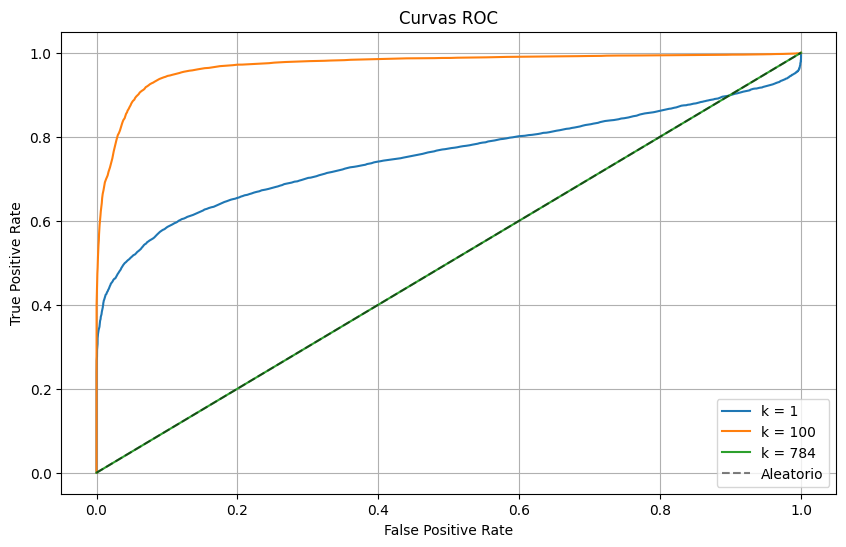

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Curvas ROC')

for i in range(len(k_values)):
  TPR, FPR = curva_ROC(Y_test_anom, ECM_anom[i], max(ECM_anom[1]))
  plt.plot(FPR, TPR, label = "k = " + str(k_values[i]))

x = np.linspace(0, 1, 1000)
plt.plot(x, x, label='Aleatorio', linestyle = '--', color = 'black', alpha = 0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.show()

&ensp; El gráfico muestra cómo varía el desempeño del clasificador según la cantidad de componentes principales utilizados. Para $k = 1$, el desempeño es el más bajo, ya que, el algoritmo *PCA* conserva muy poca información del conjunto original, lo que limita su capacidad de clasificación. En cambio, con $k = 100$, se observa un desempeño significativamente mejor, con una curva *ROC* que se aproxima a la ideal, lo que indica que con una cantidad moderada de componentes se logra una representación suficiente para una buena clasificación. Sin embargo, al utilizar los $k = 784$ componentes (equivalente a conservar todos los autovalores y autovectores), el desempeño empeora considerablemente respecto a los casos anteriores. Esto se debe a que, al conservar todos los componentes, no hay compresión y el modelo reconstruye con alta fidelidad tanto imágenes conocidas como desconocidas, entonces como el ECM tiende a cero, el clasificador no puede distinguir entre clases, lo que hace que elija la clase al azar.



&ensp; Por último, se muestran $10$ imágenes reconstruidas al azar con los diferentes valores de $k$. Para ello, se utiliza la función desarrollada con antelidad: $\texttt{plot\_10\_images}$.

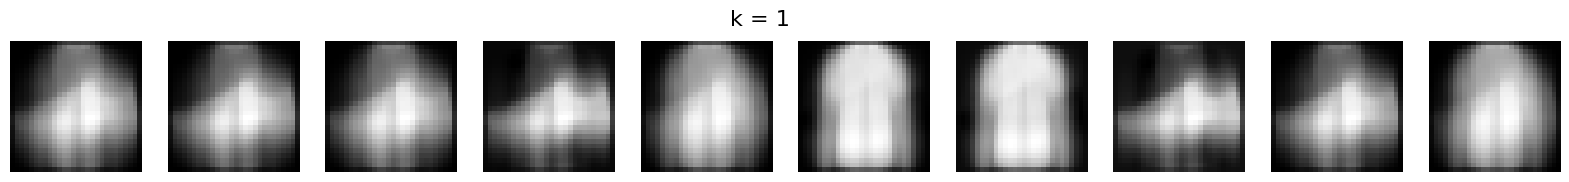

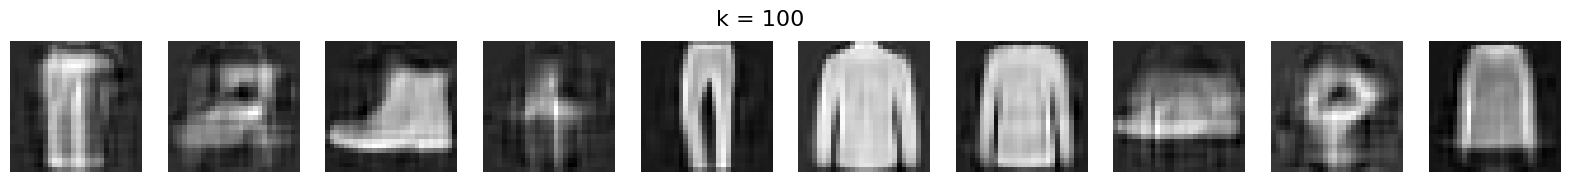

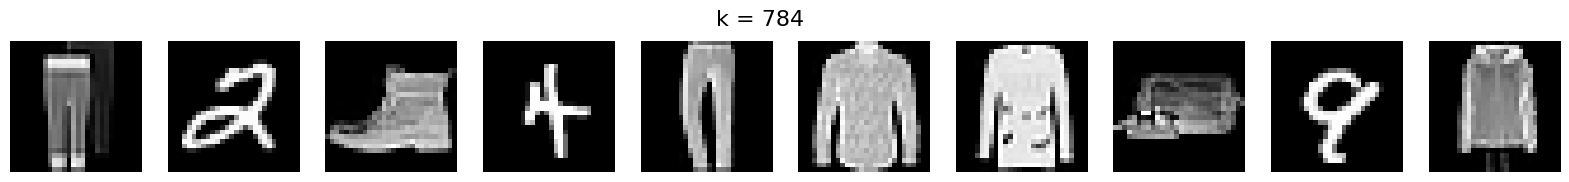

In [ ]:
X_hat_anom = X_hat_anom.reshape(X_hat_anom.shape[0], X_hat_anom.shape[1], 28, 28)
plot_10_images(X_hat_anom, k_values)

&ensp; De esta manera, se muestra claramente que para $K = 784$ se reconstruyen perfectamente tanto las prendas como los dígitos, entonces el ECM será nulo y el clasificador de anomalías seguirá a uno aleatorio. También, se puede ver cómo en el caso de $k = 1$, no se diferencian los datos de *MNIST* de los de *Fashion MNIST*, mientras que, para $k = 100$, las prendas se reconstruyen de una forma fiable y se pueden diferenciar de los dígitos.

&ensp; Así, se demuestran a partir de las imágenes reconstruidas las conclusiones extraídas de las curvas ROC.

---
---

<div style="text-align: center;">
  <h3> Conclusiones
</div>

&ensp; A lo largo de este trabajo se pudo observar cómo el algoritmo *PCA* permite una compresión de datos, logrando reducir la dimensionalidad del espacio de entrada sin una pérdida significativa de información. Así, se asemeja a la idea de los *autoencoders*, mencionada en el informe.

&ensp; También, se analizó que el porcentaje de energía aumenta logarítmicamente en función de la cantidad de componentes principales que se tienen en cuenta, mientras que, el error cuadrático medio disminuye de la misma forma. Esto último tiene sentido, ya que, al tomar mayor cantidad de autovalores y autovectores, se tiene mayor información para reconstruir los datos precisamente.

&ensp; Por otro lado, los resultados en el inciso **(E)** mostraron que con un número reducido de componentes principales, por ejemplo, $100$ de $784$, es posible obtener reconstrucciones que distinguen las prendas. Esto demuestra la eficiencia del método para reconstruir de imágenes.

&ensp; En cuanto a la detección de anomalías, el *PCA* demostró un desempeño razonable al clasificar con los primeros $100$ componentes principales. En cambio, para $k = 1$, se observó un desempeño notablemente peor, que se le atribuye a la poca información que se tiene para reconstruir, lo cual genera un error muy alto tanto para las prendas como para los dígitos. Mientras que, para $k = 784$, al utilizar la totalidad de los componentes, el modelo reconstruye perfectamente todas las imágenes, lo que impide distinguir entre las originales y las de las anomalías por medio del error cuadrático medio, haciendo que se clasifique al azar.

&ensp; En conclusión, este trabajo permitió entender el algoritmo *PCA* y desarrollar su aplicación práctica en $\texttt{Python}$.